In [32]:
import glob
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [11]:


# Load and preprocess the images
x_original = []
y_original = []

# Process healthy cows images
for alamat_gambar in glob.glob("dataset/coccidiosis/*.jpg"):
    gambar = cv2.imread(alamat_gambar)
    gambar = cv2.resize(gambar, (64, 64))
    x_original.append(gambar)
    y_original.append(0)

# Process lumpycows images
for alamat_gambar in glob.glob("dataset/healthychicken/*.jpg"):
    gambar = cv2.imread(alamat_gambar)
    gambar = cv2.resize(gambar, (64, 64))
    x_original.append(gambar)
    y_original.append(1)

# Process healthychicken images
for alamat_gambar in glob.glob("dataset/healthycows/*.jpg"):
    gambar = cv2.imread(alamat_gambar)
    gambar = cv2.resize(gambar, (64, 64))
    x_original.append(gambar)
    y_original.append(2)

# Process salmonella images
for alamat_gambar in glob.glob("dataset/lumpycows/*.jpg"):
    gambar = cv2.imread(alamat_gambar)
    gambar = cv2.resize(gambar, (64, 64))
    x_original.append(gambar)
    y_original.append(3)

# Process coccidiosis images
for alamat_gambar in glob.glob("dataset/salmonella/*.jpg"):
    gambar = cv2.imread(alamat_gambar)
    gambar = cv2.resize(gambar, (64, 64))
    x_original.append(gambar)
    y_original.append(4)

x_original = np.asarray(x_original)
y_original = np.asarray(y_original)

# Shuffle the data
z = list(zip(x_original, y_original))
random.shuffle(z)
x_original, y_original = zip(*z)
x_original = np.asarray(x_original)
y_original = np.asarray(y_original)

# Preprocess data
x_original = x_original.astype('float32') / 255.0
y_original = to_categorical(y_original, num_classes=5)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_original, y_original, test_size=0.3, random_state=42)

# Further split the training set into a validation set if needed
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create an image data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the data generator on the training set
datagen.fit(X_train)

# Verify the shapes of the split datasets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (4725, 64, 64, 3)
Validation set shape: (1182, 64, 64, 3)
Testing set shape: (2532, 64, 64, 3)


In [13]:
x_original.shape

(8439, 64, 64, 3)

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') > 0.99):

      # Stop if threshold is met
      print("\nAccuracy higher than 0.9 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [48]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 6, 6, 128)       

In [16]:
#import tensorflow as tf
#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
 #   try:
  #      tf.config.experimental.set_virtual_device_configuration(
   #         gpus[0],
    #        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]  # Adjust the memory limit as needed
     #   )
      #  logical_gpus = tf.config.experimental.list_logical_devices('GPU')
       # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    #except RuntimeError as e:
     #   print(e)


In [49]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Specify the batch size and number of epochs for training
batch_size = 25
epochs = 50

# Create a generator for training data with augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3)

# Train the model
history = model.fit(
    train_generator, 
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs,
    shuffle=True,
    callbacks=[callbacks, lr_scheduler]
)


Epoch 1/50
189/189 [==============================] - 11s 49ms/step - loss: 0.9637 - accuracy: 0.6216 - val_loss: 0.8667 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 2/50
189/189 [==============================] - 9s 48ms/step - loss: 0.7120 - accuracy: 0.7323 - val_loss: 0.5930 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 3/50
189/189 [==============================] - 9s 47ms/step - loss: 0.6322 - accuracy: 0.7653 - val_loss: 0.6562 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 4/50
189/189 [==============================] - 9s 46ms/step - loss: 0.5918 - accuracy: 0.7818 - val_loss: 0.5614 - val_accuracy: 0.8020 - lr: 0.0010
Epoch 5/50
189/189 [==============================] - 9s 46ms/step - loss: 0.5267 - accuracy: 0.8038 - val_loss: 0.4953 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 6/50
189/189 [==============================] - 9s 45ms/step - loss: 0.5000 - accuracy: 0.8214 - val_loss: 0.4851 - val_accuracy: 0.8071 - lr: 0.0010
Epoch 7/50
189/189 [==============================] - 9s 46ms/s

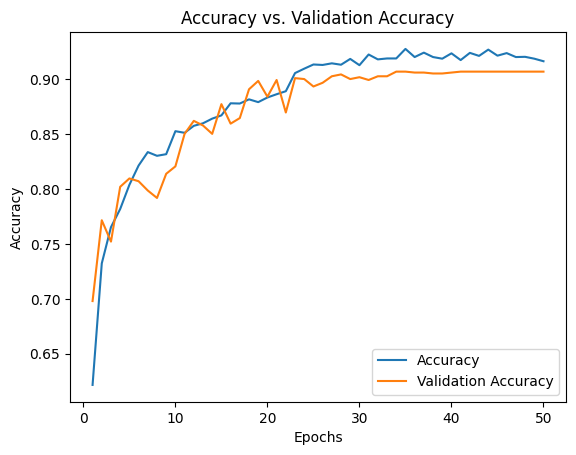

In [50]:
import matplotlib.pyplot as plt
# Get the accuracy and validation accuracy values from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a list of epochs
epochs = range(1, len(accuracy) + 1)

# Plotting the accuracy and validation accuracy
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Validation Accuracy')

# Adding legend
plt.legend()

# Display the plot
plt.show()


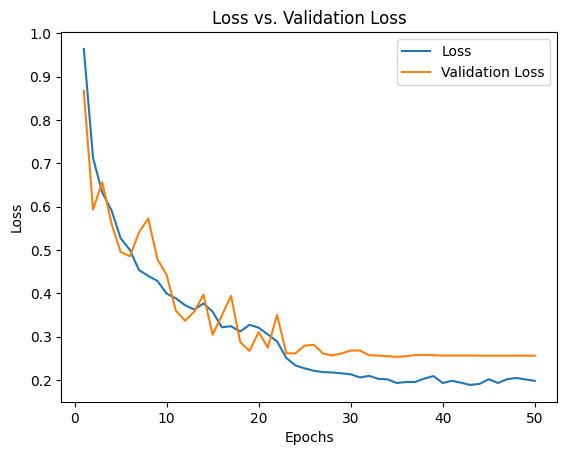

In [51]:
# Get the loss and validation loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epochs
epochs = range(1, len(loss) + 1)

# Plotting the loss and validation loss
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Validation Loss')

# Adding legend
plt.legend()

# Display the plot
plt.show()


In [52]:
import glob
import cv2
import numpy as np

kamus = {0: "Cocciodiosis", 1: "Healthy Chickens", 2: "Healthy Cows", 3: "Lumpy Cows", 4: "Salmonella"}

test_folders = [
    "dataset/coccidiosis/*.jpg",
    "dataset/healthychicken/*.jpg",
    "dataset/healthycows/*.jpg",
    "dataset/lumpycows/*.jpg",
    "dataset/salmonella/*.jpg"
]

all_predictions = []

for folder in test_folders:
    X_test = []
    for alamat_gambar in glob.glob(folder):
        gambar = cv2.imread(alamat_gambar)
        gambar = cv2.resize(gambar, (64, 64)) / 255.0
        X_test.append(gambar)

    X_test = np.asarray(X_test)

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    kelas_prediksi = [kamus[i] for i in y_pred]
    all_predictions.append(kelas_prediksi)

for folder, predictions in zip(test_folders, all_predictions):
    folder_name = folder.split("/")[-2]
    print("Predictions for", folder_name)
    print(predictions)
    print("Class Counts:")
    class_counts = {kamus[k]: predictions.count(kamus[k]) for k in kamus}
    total_predictions = len(predictions)
    class_percentages = {k: (v / total_predictions) * 100 for k, v in class_counts.items()}

    # Sort class percentages in descending order
    sorted_class_percentages = {k: v for k, v in sorted(class_percentages.items(), key=lambda item: item[1], reverse=True)}

    print(sorted_class_percentages)
    print()


83/83 [==============================] - 1s 8ms/step
Predictions for coccidiosis
['Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocciodiosis', 'Cocci

In [33]:
print(tf.__version__)

2.10.1


In [54]:
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [55]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

In [21]:
# Save the model as an h5 file
model.save('modelSapiAyam.h5')
